<a href="https://colab.research.google.com/github/yiruchen4/Chen2025/blob/main/Code/ChenFigure5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from scipy.stats import friedmanchisquare, wilcoxon
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from IPython.display import Image
import warnings

warnings.filterwarnings("ignore")

In [2]:
# @title Figure 5A
Image(url='https://github.com/yiruchen4/Chen2025/blob/main/Images/Figure%204A.png?raw=true', width=1000)

Friedman test p-value: 0.04979
Wilcoxon test p-values: 
Saline vs. SCH23390 (bonferroni-corrected): 0.02608
Saline vs. haloperidol (bonferroni-corrected): 0.02127
Friedman test p-value: 0.11916
Wilcoxon test p-values: 
Saline vs. SCH23390 (bonferroni-corrected): 0.62002
Saline vs. haloperidol (bonferroni-corrected): 0.10842
Friedman test p-value: 0.00728
Wilcoxon test p-values: 
Saline vs. SCH23390 (bonferroni-corrected): 1.00000
Saline vs. haloperidol (bonferroni-corrected): 0.00049
Friedman test p-value: 0.00439
Wilcoxon test p-values: 
Saline vs. SCH23390 (bonferroni-corrected): 0.78198
Saline vs. haloperidol (bonferroni-corrected): 0.00122


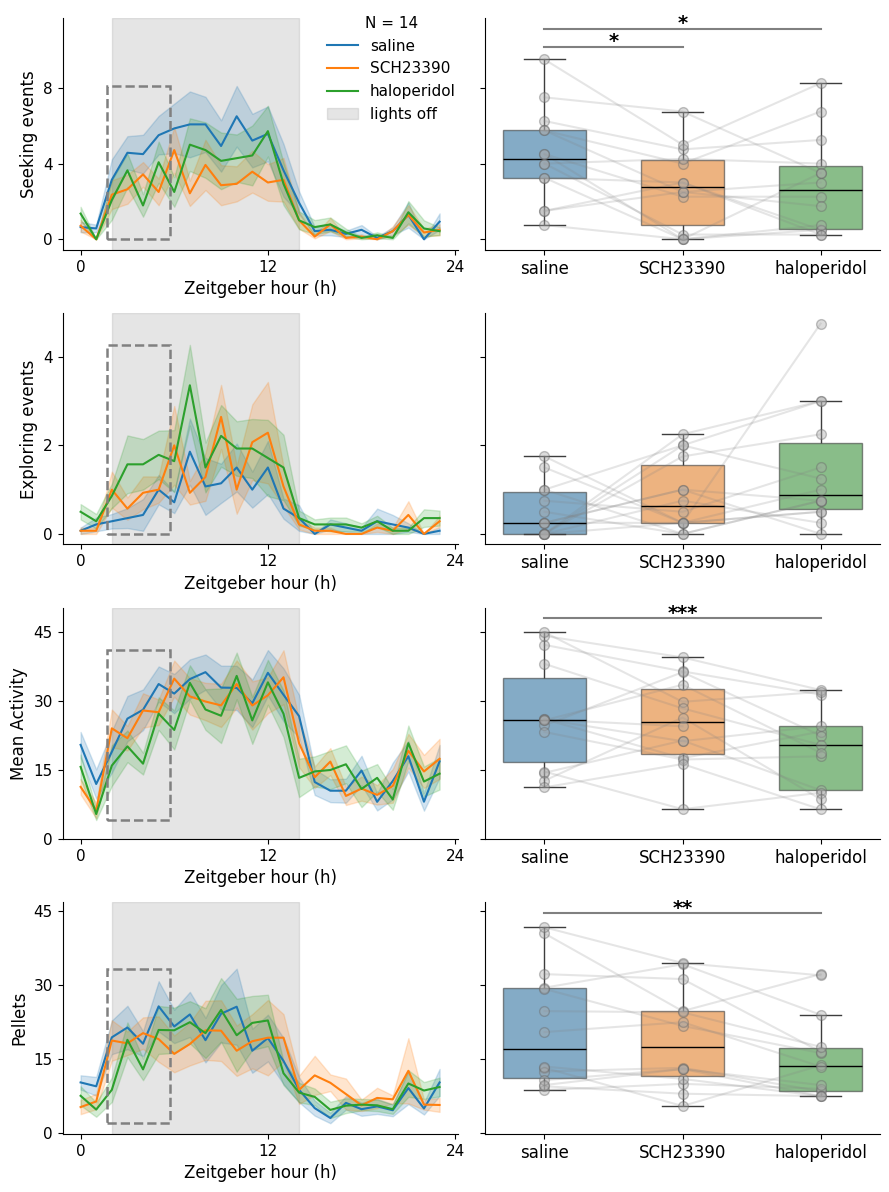

In [6]:
# @title Figure 5B-E
def process_and_plot_behavior_panel(raw_dfs, titles, colors):
    """
    From raw input DataFrames, filters, groups, analyzes, and plots a 2x4 panel.
    Top row: time-course (line) plots. Bottom row: bar/strip/stats.
    """
    fig, axes = plt.subplots(4, 2, figsize=(9, 12), sharey='row')
    treatment_order = ['saline', 'SCH23390', 'haloperidol']

    for col_idx, (metric, title) in enumerate(zip(raw_dfs.keys(), titles)):
        df = raw_dfs[metric]

        # Filter: zthour 2–5
        filtered_df = df[(df['zthour'] >= 2) & (df['zthour'] <= 5)]

        # Top row: Line plot
        ax_top = axes[col_idx, 0]
        # Determine correct y-axis column
        if metric == 'activity':
            y_col = 'activity'
        elif metric == 'feeding':
            y_col = 'pellets'
        else:
            y_col = 'event'

        sns.lineplot(data=df, x='zthour', y=y_col, hue='treatment', errorbar='se', ax=ax_top,palette=colors)

        import matplotlib.patches as patches

        # Add a dashed rectangle from zthour 2 to 5
        # Group and compute errorbars (standard error)
        grouped_line = df.groupby(['zthour', 'treatment'])[y_col].agg(['mean', 'sem']).reset_index()
        grouped_line['lower'] = grouped_line['mean'] - grouped_line['sem']
        grouped_line['upper'] = grouped_line['mean'] + grouped_line['sem']

        # Get min/max across all groups
        y_min = grouped_line['lower'].min()
        y_max = grouped_line['upper'].max()
        highlight_box = patches.Rectangle(
            (1.7, y_min),               # (x, y) = bottom-left corner
            4,                        # width = 5 - 2
            y_max - y_min,              # height
            linewidth=1.8,
            edgecolor='gray',
            linestyle='--',
            facecolor='none',
            zorder=2
        )
        ax_top.add_patch(highlight_box)

        ax_top.axvspan(2, 14, color='gray', alpha=0.2, zorder=0, label='lights off')
        ax_top.set_xlabel('Zeitgeber hour (h)', fontsize=12)
        ax_top.set_xticks([0, 12, 24])
        ax_top.set_xticklabels(['0', '12', '24'], fontsize=11)
        ax_top.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
        ax_top.tick_params(axis='y', labelsize=11)
        ax_top.tick_params(axis='x', labelsize=11)
        if col_idx == 0:
            ax_top.legend(title=f'N = {len(filtered_df["device_number"].unique())}', title_fontsize=11, loc='upper right', bbox_to_anchor=(1.03, 1.07), frameon=False, fontsize=11)
        else:
            ax_top.get_legend().remove()


        # Bottom row: Summary bar plot + stats
        ax_bot = axes[col_idx, 1]
        if metric == 'activity':
            grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['activity'].mean().reset_index(name='value')
            ylabel = "Mean Activity"
        elif metric == 'feeding':
            grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['pellets'].mean().reset_index(name='value')
            ylabel = f"Pellets"
        else:
            grouped = filtered_df.groupby(['device_number', 'treatment', 'sex'])['event'].mean().reset_index(name='value')
            ylabel = f"{metric.capitalize()} events"

        # Set treatment order
        grouped['treatment'] = pd.Categorical(grouped['treatment'], categories=treatment_order, ordered=True)

        # Bar plot
        palette = [colors[t] for t in treatment_order]

        # Box plot with colored edges (palette applies here)
        sns.boxplot(
            data=grouped,
            x='treatment',
            y='value',
            palette=palette,
            ax=ax_bot,
            width=0.6,
            showcaps=True,
            boxprops=dict(alpha=0.6),  # partly transparent
            medianprops=dict(color='black'),
            showfliers=False
        )

        # Strip plot
        sns.stripplot(data=grouped, x='treatment', y='value', dodge=False, jitter=False, size=7,
                      marker='o', alpha=0.4, color='darkgray', linewidth=1, ax=ax_bot)

        # OPTIONAL: Set box fill manually to match bar color
        for patch, treatment in zip(ax_bot.artists, treatment_order):
            patch.set_facecolor(treatment_color_map[treatment])
            patch.set_edgecolor('black')
            patch.set_alpha(0.6)

        # Connect dots per subject
        for device_id, sub in grouped.groupby('device_number'):
            sorted_sub = sub.sort_values('treatment')
            ax_bot.plot(sorted_sub['treatment'], sorted_sub['value'], linestyle='-', alpha=0.2, color='gray')

        ax_bot.set_xlabel('')
        ax_bot.set_ylabel(ylabel, fontsize=12)
        ax_top.set_ylabel(ylabel, fontsize=12)
        ax_bot.yaxis.set_major_locator(MaxNLocator(nbins=4, integer=True))
        ax_bot.tick_params(axis='y', labelsize=11)
        ax_bot.tick_params(axis='x', labelsize=12)

        # Friedman + Wilcoxon stats
        anova_df = grouped.pivot(index='device_number', columns='treatment', values='value').dropna()
        if all(t in anova_df.columns for t in treatment_order):
            stat, p = friedmanchisquare(anova_df['saline'], anova_df['SCH23390'], anova_df['haloperidol'])
            print(f'Friedman test p-value: {p:.5f}')
            p1 = wilcoxon(anova_df['saline'], anova_df['SCH23390']).pvalue
            p2 = wilcoxon(anova_df['saline'], anova_df['haloperidol']).pvalue
            # Wilcoxon tests
            p1_raw = wilcoxon(anova_df['saline'], anova_df['SCH23390']).pvalue
            p2_raw = wilcoxon(anova_df['saline'], anova_df['haloperidol']).pvalue

            # Bonferroni correction for 2 comparisons
            p1 = min(p1_raw * 2, 1.0)
            p2 = min(p2_raw * 2, 1.0)
            print("Wilcoxon test p-values: ")
            print(f"Saline vs. SCH23390 (bonferroni-corrected): {p1:.5f}")
            print(f"Saline vs. haloperidol (bonferroni-corrected): {p2:.5f}")

            # Get max y for placement
            y_max = grouped['value'].max()
            y_offset = y_max * 0.05  # height between lines
            base_y = y_max * 1.02

            def add_sig_line(ax, x1, x2, y, p_val):
                if p_val < 0.0001:
                    stars = '****'
                elif p_val < 0.001:
                    stars = '***'
                elif p_val < 0.01:
                    stars = '**'
                elif p_val < 0.05:
                    stars = '*'
                else:
                    return  # not significant

                # ax.plot([x1, x1, x2, x2], [y, y + y_offset, y + y_offset, y], lw=1.5, c='k')
                ax.plot([x1, x2], [y + y_offset, y + y_offset], lw=1.5, c='gray')
                ax.text((x1 + x2) / 2, y + y_offset - (y_offset * 0.45), stars,
                        ha='center', va='bottom', fontsize=14, fontweight='bold')

            # Bar x-locations
            x_map = {'saline': 0, 'SCH23390': 1, 'haloperidol': 2}
            if p1 < 0.05:
                add_sig_line(ax_bot, x_map['saline'], x_map['SCH23390'], base_y, p1)
                base_y += y_offset * 2  # push next one up
            if p2 < 0.05:
                add_sig_line(ax_bot, x_map['saline'], x_map['haloperidol'], base_y, p2)

        y = ax_bot.get_ylim()
        ax_bot.set_ylim([min(y[0],0), y[1]])

    sns.despine()
    plt.tight_layout()
    fig.savefig('batch46_behavior_panel_4x2_boxplot', transparent=True, bbox_inches='tight', dpi=600)
    plt.show()

# Define color mapping
default_palette = sns.color_palette()
treatment_color_map = {
    'saline': default_palette[0],        # blue
    'SCH23390': default_palette[1],      # orange
    'haloperidol': default_palette[2]    # green
}

# Load CSVs
df_activity = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_d.csv")
df_seeking = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_b.csv")
df_exploring = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_c.csv")
df_feeding = pd.read_csv(r"https://raw.githubusercontent.com/yiruchen4/Chen2025/main/Data/data_Figure5_e.csv")

raw_dfs = {
    'seeking': df_seeking,
    'exploring': df_exploring,
    'activity': df_activity,
    'feeding': df_feeding
}
titles = ['Seeking','Exploring','Activity','Feeding']
process_and_plot_behavior_panel(raw_dfs, titles, treatment_color_map)